# Stroke Prediction AI

### Install library yang dibutuhkan

In [29]:
%pip install optuna pandas scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


### 1. Siapkan data

In [30]:
import pandas as pd

df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### 2. Lakukan Preprocessing

In [31]:
# Cek nilai yang hilang
print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Terdapat nilai yang hilang pada kolom BMI, sehingga kita akan mengisi nilai tersebut dengan nilai rata-rata dari kolom tersebut.

In [32]:
from sklearn.impute import SimpleImputer

# Mengisi nilai yang hilang pada kolom bmi dengan nilai rata-rata
imputer = SimpleImputer(strategy='mean')
df['bmi'] = imputer.fit_transform(df[['bmi']])

print(df.isnull().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [33]:
# tampilkan semua kemungkinan nilai dari setiap kolom
for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    print(f'{col}: {df[col].unique()}')

gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


Terdapat kolom yang berisi data kategorikal, yaitu kolom 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'. Kita akan melakukan 

In [55]:
from sklearn.preprocessing import LabelEncoder

# Melakukan label encoding, mengubah nilai kategori menjadi nilai numerik
label_encoders = {}
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    
# Menampilkan hasil label encoding
for col in categorical_columns:
    print(f'{col}: {df[col].unique()}')
    

gender: [1 0 2]
ever_married: [1 0]
work_type: [2 3 0 4 1]
Residence_type: [1 0]
smoking_status: [1 2 3 0]


In [35]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


Hapus kolom 'id' karena tidak relevan dengan model.

In [36]:
# Hapus kolom id
df.drop(columns=['id'], inplace=True)

# Menampilkan data setelah id dihapus
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


Pisahkan kolom Features dan Target.

In [37]:
X = df.drop(columns=['stroke'])
y = df['stroke']

### 3. Split data

kita akan membagi data menjadi data training dan data testing dengan perbandingan 80:20.

In [38]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

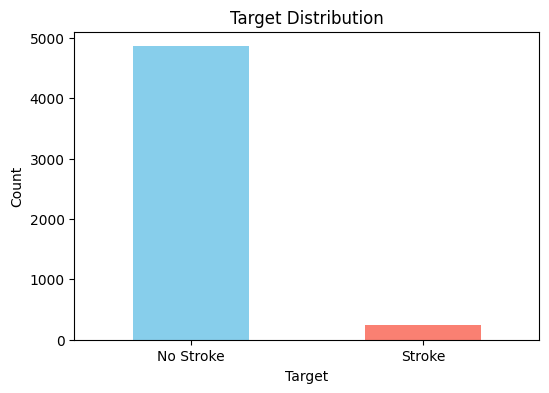

In [39]:
import matplotlib.pyplot as plt

# Menampilkan distribusi target
plt.figure(figsize=(6, 4))
df['stroke'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'], title='Target Distribution')
plt.xticks([0, 1], ['No Stroke', 'Stroke'], rotation=0)
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

Terlihat pada grafik di atas, distribusi nilai target tidak seimbang. Oleh karena itu, kita akan menggunakan SMOTE untuk menyeimbangkan data.

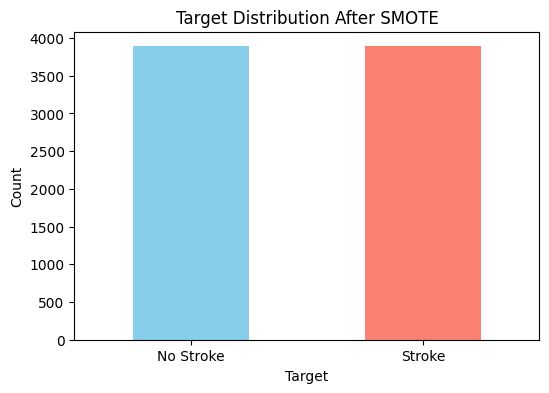

In [40]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Menampilkan distribusi target setelah resampling
plt.figure(figsize=(6, 4))
pd.Series(y_train_resampled).value_counts().plot(kind='bar', color=['skyblue', 'salmon'], title='Target Distribution After SMOTE')
plt.xticks([0, 1], ['No Stroke', 'Stroke'], rotation=0)
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

### 4. Mebuat Model

Kita akan menggunakan model Gradient Boosting Classifier.
- Kinerja Tinggi: Mampu menangkap pola kompleks dalam data medis yang seringkali non-linear.
- Penanganan Ketidakseimbangan Data: Cocok untuk dataset stroke yang mungkin memiliki distribusi kelas tidak merata (misalnya, lebih banyak non-stroke).
- Robust terhadap Outlier: Efektif menghadapi data dengan outlier, seperti nilai ekstrim tekanan darah atau kadar glukosa.
- Kemampuan Fitur Importance: Membantu mengidentifikasi faktor risiko utama stroke, seperti usia, hipertensi, dan diabetes.
- Fleksibilitas: Cocok untuk dataset kecil hingga besar, tanpa memerlukan banyak preprocessing.
- Pengendalian Overfitting: Hyperparameter seperti learning rate dan n_estimators memungkinkan kontrol yang baik terhadap overfitting.
- Iterasi Bertahap: Meningkatkan performa secara bertahap dengan meminimalkan kesalahan model sebelumnya.

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    random_state=100,
    max_features=5 
)

gbc.fit(X_train_resampled, y_train_resampled)

predictions = gbc.predict(X_test)

### 5. Evaluasi Model

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Menampilkan hasil
print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(f'Classification Report:\n{classification_report(y_test, predictions)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, predictions)}')

Accuracy: 0.8346379647749511
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       972
           1       0.14      0.46      0.21        50

    accuracy                           0.83      1022
   macro avg       0.55      0.66      0.56      1022
weighted avg       0.93      0.83      0.87      1022

Confusion Matrix:
[[830 142]
 [ 27  23]]


Accuracy 0.83, kita masih bisa meningkatkan performa model dengan mencari parameter terbaik menggunakan optuna.

In [43]:
import optuna

# Fungsi objective yang akan dioptimasi oleh optuna
def objective(trial: optuna.Trial) -> float:
    '''
    n_estimators: jumlah pohon yang akan dibuat
    learning_rate: laju pembelajaran
    max_depth: kedalaman maksimum pohon
    '''
    param_space = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 250, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
    }

    # inisialisasi model dengan hyperparameter yang dihasilkan oleh optuna
    gb_model = GradientBoostingClassifier(**param_space, validation_fraction=0.1, n_iter_no_change=5, random_state=42)

    # Melatih model
    gb_model.fit(X_train_resampled, y_train_resampled)

    # Memprediksi data uji
    y_pred = gb_model.predict(X_test)

    # Menghitung akurasi
    accuracy = accuracy_score(y_test, y_pred)

    return 1.0 - accuracy  # optuna akan mencari nilai minimum, sehingga kita perlu mengubah nilai akurasi menjadi error

# melakukan optimasi hyperparameter
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Membuat model dengan hyperparameter terbaik yang dihasilkan oleh optuna
best_params_optuna = study.best_params
best_model_optuna = GradientBoostingClassifier(**best_params_optuna, validation_fraction=0.1, n_iter_no_change=5, random_state=42)

# Melatih model
best_model_optuna.fit(X_train_resampled, y_train_resampled)

# Memprediksi data uji dengan model terbaik
y_pred_best_optuna = best_model_optuna.predict(X_test)


[I 2024-12-16 09:58:31,847] A new study created in memory with name: no-name-79982a4a-0ea7-462e-b6f2-03882fc9db7b
[I 2024-12-16 09:58:33,050] Trial 0 finished with value: 0.14970645792563597 and parameters: {'n_estimators': 50, 'learning_rate': 0.19683816886206937, 'max_depth': 4}. Best is trial 0 with value: 0.14970645792563597.
[I 2024-12-16 09:58:36,964] Trial 1 finished with value: 0.13111545988258322 and parameters: {'n_estimators': 100, 'learning_rate': 0.07179000858801927, 'max_depth': 6}. Best is trial 1 with value: 0.13111545988258322.
[I 2024-12-16 09:58:37,795] Trial 2 finished with value: 0.1927592954990215 and parameters: {'n_estimators': 50, 'learning_rate': 0.17061475361568398, 'max_depth': 3}. Best is trial 1 with value: 0.13111545988258322.
[I 2024-12-16 09:58:42,779] Trial 3 finished with value: 0.10176125244618395 and parameters: {'n_estimators': 250, 'learning_rate': 0.0929787088082754, 'max_depth': 4}. Best is trial 3 with value: 0.10176125244618395.
[I 2024-12-16 

In [44]:
# Menampilkan hasil setelah hyperparameter tuning
print(f'Accuracy: {accuracy_score(y_test, y_pred_best_optuna)}')
print(f'Classification Report:\n{classification_report(y_test, y_pred_best_optuna)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred_best_optuna)}')

Accuracy: 0.9285714285714286
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       972
           1       0.26      0.24      0.25        50

    accuracy                           0.93      1022
   macro avg       0.61      0.60      0.60      1022
weighted avg       0.93      0.93      0.93      1022

Confusion Matrix:
[[937  35]
 [ 38  12]]


Nilai accuracy meningkat cukup signifikan setelah menggunakan teknik hyperparameter tuning, dari 0.83 menjadi 0.92

In [45]:
# save model
import joblib

joblib.dump(best_model_optuna, '../bin/model.pkl')

['./bin/model.pkl']